# How to Predict Heart Disease using Logistic Regression

## Import Library

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

## Data Preparation

In [2]:
df = pd.read_csv('framingham.csv')
df.drop(['education'],axis=1,inplace=True)
df.rename(columns={'male':'sex_male'},inplace=True)
df.head()

,sex,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Missing Values

In [3]:
df.isnull().sum()

sex                  0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [4]:
count = 0
for i in df.isnull().sum(axis=1):
    if i > 0:
        count = count+1
print('Total number of rows with missing values is', count)

print('Since it is only', round((count/len(df.index))*100), 'percent of the entire dataset the rows with missing values are excluded')

Total number of rows with missing values is 489
Since it is only 12 percent of the entire dataset the rows with missing values are excluded


In [5]:
df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3751 entries, 0 to 4239
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              3751 non-null   int64  
 1   age              3751 non-null   int64  
 2   currentSmoker    3751 non-null   int64  
 3   cigsPerDay       3751 non-null   float64
 4   BPMeds           3751 non-null   float64
 5   prevalentStroke  3751 non-null   int64  
 6   prevalentHyp     3751 non-null   int64  
 7   diabetes         3751 non-null   int64  
 8   totChol          3751 non-null   float64
 9   sysBP            3751 non-null   float64
 10  diaBP            3751 non-null   float64
 11  BMI              3751 non-null   float64
 12  heartRate        3751 non-null   float64
 13  glucose          3751 non-null   float64
 14  TenYearCHD       3751 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 468.9 KB


## Exploratory Visual Analysis

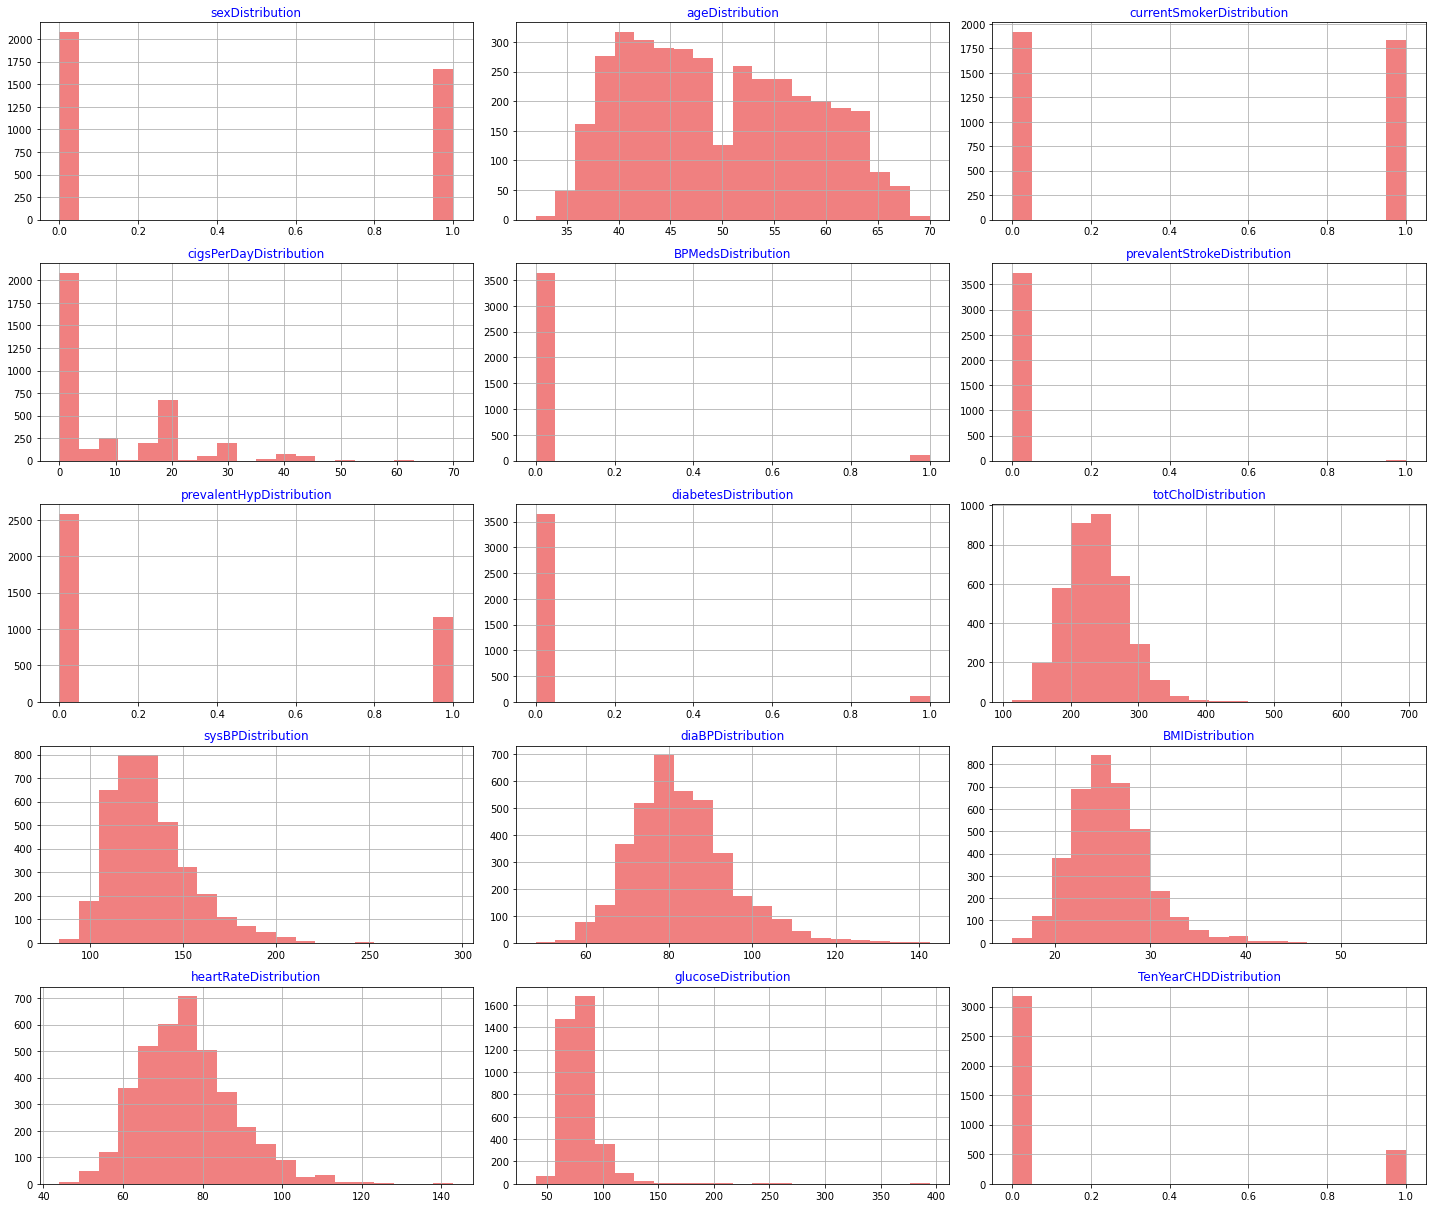

In [6]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='lightcoral')
        ax.set_title(feature+"Distribution", color='blue')
    fig.tight_layout()
    plt.show()
draw_histograms(df, df.columns, 6, 3)

Count CHD

In [7]:
df.TenYearCHD.value_counts()

0    3179
1     572
Name: TenYearCHD, dtype: int64

<AxesSubplot:xlabel='TenYearCHD', ylabel='count'>

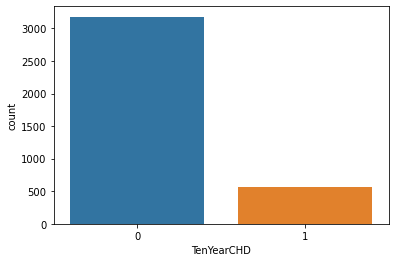

In [8]:
sn.countplot(x='TenYearCHD', data=df)

There are 3179 patients with no heart disease and 572 patients with risk of heart disease

Test

In [9]:
df.describe()

,sex,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.445215,49.573447,0.488403,9.008531,0.030392,0.005599,0.311917,0.027193,236.928019,132.368435,82.938550,25.808288,75.704079,81.880032,0.152493
std,0.497056,8.570204,0.499932,11.925097,0.171686,0.074623,0.463338,0.162666,44.611594,22.046522,11.932779,4.065599,11.956382,23.882233,0.359546
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.085000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.410000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.000000,28.060000,82.000000,87.000000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


## Logistic Regression

In [10]:
from statsmodels.tools import add_constant as add_constant
df_constant = add_constant(df)
df_constant.head()

,const,sex,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [11]:
st.chisqprob = lambda chisq, df: st.chi2.sf(chisq, df)
cols = df_constant.columns[:-1]
model=sm.Logit(df.TenYearCHD, df_constant[cols])
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.377036
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3736
Method:                           MLE   Df Model:                           14
Date:                Sat, 17 Apr 2021   Pseudo R-squ.:                  0.1170
Time:                        20:40:08   Log-Likelihood:                -1414.3
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 2.439e-71
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.6532      0.687    -12.589      0.000     -10.000      -7.306
sex                 0.5742      0.107      5.345      0.000       0.364       0.785
age                 0.0641      0.007      9.799      0.000       0.051       0.077
currentSmoker       0.0739      0.155      0.478      0.633      -0.229       0.377
cigsPerDay          0.0184      0.006      3.000      0.003       0.006       0.030
BPMeds              0.1448      0.232      0.623      0.533      -0.310       0.600
prevalentStroke     0.7193      0.489      1.471      0.141      -0.239       1.678
prevalentHyp        0.2142      0.136      1.571      0.116      -0.053       0.481
diabetes            0.0022      0.312      0.007      0.994      -0.610       0.614
totChol             0.0023      0.001      2.081      0.037       0.000       0.004
sysBP               0.0154      0.004      4.082      0.000       0.008       0.023
diaBP              -0.0040      0.006     -0.623      0.533      -0.016       0.009
BMI                 0.0103      0.013      0.827      0.408      -0.014       0.035
heartRate          -0.0023      0.004     -0.549      0.583      -0.010       0.006
glucose             0.0076      0.002      3.409      0.001       0.003       0.012
===================================================================================
"""

The result above show some of the attributes with P value higher than the preferred alpha (5%) and thereby **showing low statistically significant relationship with the probability of heart disease**

Backward elemination approach is used here to remove those attributes with highest Pvalue one at a time followed by running the regression repeatedly until all attributes have P Values less than 0.05.

## Feature Selection: Backward elemination (P-value approach)

Takes in the dataframe, the dependent variable and a list of column names, runs the regression repeatedly **eleminating feature with the highest P-value above alpha one at a time** and returns the regression summary with all p-values below alpha

In [12]:
def back_feature_elem (data_frame, dep_var, col_list):
    while len(col_list)>0 :
        model = sm.Logit(dep_var,data_frame[col_list])
        result = model.fit(disp=0)
        largest_pvalue = round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list = col_list.drop(largest_pvalue.index)
result = back_feature_elem(df_constant, df.TenYearCHD, cols)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3744
Method:                           MLE   Df Model:                            6
Date:                Sat, 17 Apr 2021   Pseudo R-squ.:                  0.1149
Time:                        20:40:08   Log-Likelihood:                -1417.7
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 2.127e-76
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1264      0.468    -19.504      0.000     -10.043      -8.209
sex            0.5815      0.105      5.524      0.000       0.375       0.788
age            0.0655      0.006     10.343      0.000       0.053       0.078
cigsPerDay     0.0197      0.004      4.805      0.000       0.012       0.028
totChol        0.0023      0.001      2.106      0.035       0.000       0.004
sysBP          0.0174      0.002      8.162      0.000       0.013       0.022
glucose        0.0076      0.002      4.574      0.000       0.004       0.011
==============================================================================
"""

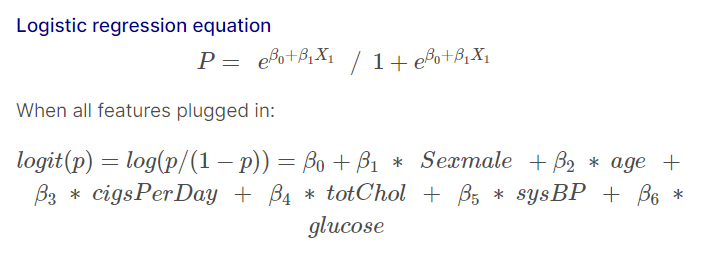

## Interpreting: Odds Ratio, Confidence Intervals and Pvalues

In [13]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = params
pvalue = round(result.pvalues,3)
conf['pvalue'] = pvalue
conf.columns = ['CI 95%(2.5%)','CI 95%(97.5%)', 'Odds Ratio', 'pvalue']
print((conf))

            CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
const           0.000043       0.000272    0.000109   0.000
sex             1.455242       2.198536    1.788687   0.000
age             1.054483       1.080969    1.067644   0.000
cigsPerDay      1.011733       1.028128    1.019897   0.000
totChol         1.000158       1.004394    1.002273   0.035
sysBP           1.013292       1.021784    1.017529   0.000
glucose         1.004346       1.010898    1.007617   0.000


- Holding all other features constant, the odds of getting diagnosed with heart disease for males (sex_males=1) over that of females (sex_males=0) is exp(0.5815) = 1.788687. In terms of percent change, we can say that the odds for males are 78.8% higher than the odds for females

- The coefficient for age says that, holding all others constant, we will see 7% increase in the odds of getting diagnosed with CDH for a one year increase in age since exp(0.0655) = 1.067644.

- Every extra cigarette one smokes, there is a 2% increase in the odds of CDH.

- There is a 1.7% increase in odds for every unit increase in systolic Blood Pressure.

## Splitting Data : Train and Test

In [14]:
import sklearn
new_features =  df[['age','sex','cigsPerDay','totChol','sysBP','glucose','TenYearCHD']]
x = new_features.iloc[:,:-1]
y = new_features.iloc[:,-1]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.20, random_state=5)

In [15]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Model Evaluation

### Model Accuracy

In [16]:
sklearn.metrics.accuracy_score(y_test,y_pred)

0.8748335552596538

### Confusion Matrix

<AxesSubplot:>

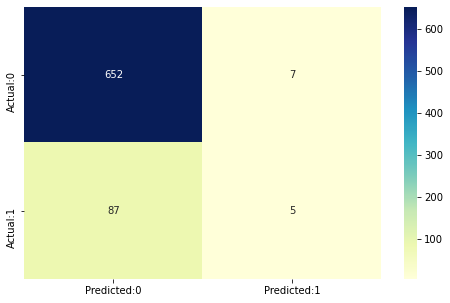

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')

The confusion matrix shows 658+4 = 662 correct predictions and 88+1= 89 incorrect ones.

**- True Positives : 4**

**- True Negatives : 658**

**- False Positives : 1 (Type I error)**

**- False Negatives : 88 (Type II error)**

In [18]:
TN = cm[0,0]
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]

sensitivity = TP/float(TP+FN)
specificity = TN/float(TN+FP)

## Model Evaluation - Statistics

In [19]:
print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Negative Predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

'Negative Likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)

The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.8748335552596538 
 The Missclassification = 1-Accuracy =  0.12516644474034622 
 Sensitivity or True Positive Rate = TP/(TP+FN) =  0.05434782608695652 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.9893778452200304 
 Positive Predictive value = TP/(TP+FP) =  0.4166666666666667 
 Negative Predictive Value = TN/(TN+FN) =  0.8822733423545331 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  5.116459627329198 
 Negative Likelihood Ratio = (1-Sensitivity)/Specificity =  0.9558048813016804


**From the above statistics it is clear that the model is highly specific than sensitive. The negative values are predicted more accurately than the positives.**

## Predicted probabilities of 0 (No Coronary Heart Disease) and 1 (Coronary Heart Disease: Yes) for the test data with a default classification threshold of 0.5

In [20]:
y_pred_prob = logreg.predict_proba(x_test)[:,:]
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Prob of no hearts disease(0)','Prob of Heart Disease (1)'])
y_pred_prob_df.head()

,Prob of no hearts disease(0),Prob of Heart Disease (1)
0,0.875004,0.124996
1,0.956172,0.043828
2,0.783493,0.216507
3,0.806604,0.193396
4,0.892856,0.107144


# Lower the Threshold

In [21]:
from sklearn.preprocessing import binarize
for i in range(1,5):
    cm2=0
    y_pred_prob_yes=logreg.predict_proba(x_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')

With 0.1 threshold the Confusion Matrix is  
 [[311 348]
 [ 12  80]] 
 with 391 correct predictions and 12 Type II errors( False Negatives) 

 Sensitivity:  0.8695652173913043 Specificity:  0.47192716236722304 



With 0.2 threshold the Confusion Matrix is  
 [[518 141]
 [ 43  49]] 
 with 567 correct predictions and 43 Type II errors( False Negatives) 

 Sensitivity:  0.532608695652174 Specificity:  0.7860394537177542 



With 0.3 threshold the Confusion Matrix is  
 [[600  59]
 [ 64  28]] 
 with 628 correct predictions and 64 Type II errors( False Negatives) 

 Sensitivity:  0.30434782608695654 Specificity:  0.9104704097116844 



With 0.4 threshold the Confusion Matrix is  
 [[640  19]
 [ 80  12]] 
 with 652 correct predictions and 80 Type II errors( False Negatives) 

 Sensitivity:  0.13043478260869565 Specificity:  0.9711684370257967 





C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.4 as keyword args. From version 0.25 passing these as positional arguments will result in an 

## ROC Curve

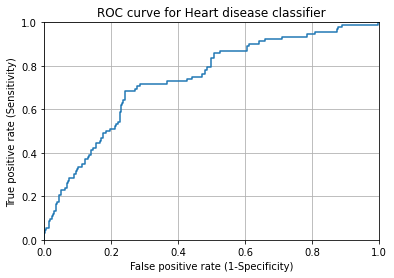

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Heart disease classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

In [23]:
sklearn.metrics.roc_auc_score(y_test,y_pred_prob_yes[:,1])

0.7386026258494425